In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [69]:
fold = "../train_raw_npy/"
xyz = np.load(f"{fold}acc_xyz.npy")
label = np.load(f"{fold}sampled_label.npy")
print(xyz.shape)
print(label.shape)


(196072, 3, 500)
(196072,)


In [77]:
#おしり3万データを使う  
xyz = xyz[-40000:-10000,:]
label = label[-40000:-10000]
xyz.shape

(30000, 3, 500)

In [78]:
import numpy as np
from sklearn.model_selection import train_test_split

# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(xyz, label, test_size=0.2, shuffle=True,random_state=40)

# 結果の確認
print(f"Train data shape: {train_xyz.shape}")
print(f"Test data shape: {test_xyz.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())
# train_randomの生成
train_xyz_random = train_xyz
train_label_random = train_label

Train data shape: (24000, 3, 500)
Test data shape: (6000, 3, 500)
Train label shape: (24000,)
Test label shape: (6000,)
1.0    4235
4.0    3917
7.0    3893
6.0    3582
2.0    3010
5.0    2964
8.0    1445
3.0     954
Name: count, dtype: int64
1.0    1041
7.0     964
4.0     960
6.0     926
5.0     774
2.0     719
8.0     373
3.0     243
Name: count, dtype: int64


In [133]:
class ConvBNReLU(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,

            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            dropout=0.0 # ドロップアウト率を新規追加
    ):
        super(ConvBNReLU, self).__init__()

        self.main = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(True)
        )
        if dropout > 0:
            self.main.append(nn.Dropout(dropout))

        # He初期化
        nn.init.kaiming_normal_(self.main[0].weight, mode='fan_out', nonlinearity='relu')
        if self.main[0].bias is not None:
            nn.init.constant_(self.main[0].bias, 0)
    
    def forward(self,x):
        return self.main(x)
    

    
class CNN(nn.Module):
    def __init__(self, output_size=8, in_channels=3, num_filters_init=8, dropout=0.0):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            ConvBNReLU(in_channels, num_filters_init, 3,1,1), # 500 -> 500
            

            ConvBNReLU(num_filters_init, num_filters_init*2, 8,2,3,dropout=dropout ), # 500->250
            
            ConvBNReLU(num_filters_init*2, num_filters_init*4, 6,2,2,dropout=dropout), # 250 -> 125 (248)
            ConvBNReLU(num_filters_init*4, num_filters_init*8,7,2,2, dropout=dropout), # 125 -> 62
            ConvBNReLU(num_filters_init*8, num_filters_init*16,6,2,1 , dropout=dropout), # 62 -> 30

            ConvBNReLU(num_filters_init*16, num_filters_init*32, 4, 2, 1, dropout=dropout), # 30 -> 15
            ConvBNReLU(num_filters_init*32, num_filters_init*64, 3, 2, 1, dropout=dropout), # 15->8

            ConvBNReLU(num_filters_init*64, num_filters_init*128, 8,1,0), # 8 -> 1 
            #nn.Conv1d(num_filters_init*128, output_size, 1,1,0) #代わりに下の全結合層を導入
        )
        # 全結合層
        self.fc = nn.Sequential(
            nn.Linear(num_filters_init*128, num_filters_init*64),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(num_filters_init*64, 128),
            nn.ReLU(True),
            nn.Dropout(dropout),

            nn.Linear(128, output_size)
        )

        nn.init.kaiming_normal_(self.fc[0].weight, mode="fan_out", nonlinearity="relu")
        nn.init.kaiming_normal_(self.fc[3].weight, mode="fan_out", nonlinearity="relu")
        

        # 最後のConv1dにもHe初期化を適用
        #nn.init.kaiming_normal_(self.cnn[-1].weight, mode='fan_out', nonlinearity='relu')
        #if self.cnn[-1].bias is not None:
        #    nn.init.constant_(self.cnn[-1].bias, 0)
        
    
    def forward(self, x):
        x = self.cnn(x).view(x.size(0), -1)
        return self.fc(x)
        #return x

In [6]:
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    if shuffle:
        idxs = np.random.permutation(np.arange(len(X)))
    else:
        idxs = np.arange(len(X))
    
    #データセットをバッチサイズごとに分割
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        X_batch = X[idxs_batch].astype('f4')

        X_batch = torch.from_numpy(X_batch)
        if y is None:
            yield X_batch
        else:
            y_batch = y[idxs_batch]
            y_batch = torch.from_numpy(y_batch-1)
            yield X_batch, y_batch


def forward_by_batches(cnn, X):
    Y = []
    cnn.eval()
    with torch.no_grad():
        for x in create_dataloader(X, batch_size=1024, shuffle=False):
            x = x.to(device)
            Y.append(cnn(x))
    cnn.train()

    Y = torch.cat(Y) # Yをテンソルに変換
    return Y


def evaluate_model(cnn, X, Y):
    Y_pred = forward_by_batches(cnn, X)
    loss = F.cross_entropy(Y_pred, torch.from_numpy(Y-1.0).type(torch.int64).to(device)).item() # クロスエントロピー損失の計算 仕方なく0~7クラス分類とする

    Y_pred = F.softmax(Y_pred, dim=1) 
    Y_pred = torch.argmax(Y_pred, dim=1)  # 最も高い確率のY_predのラベルを予測ラベルとしてY_predに入れられる。
    Y_pred = Y_pred + 1  # 予測ラベルに1を加えて1~8の範囲に変換する
    Y_pred = Y_pred.cpu().numpy()  # テンソルでGPUにのっているものをcpuに移動して、それをさらにnumpy配列に変換している。
    kappa = metrics.cohen_kappa_score(Y, Y_pred) # 1~8クラス分類

    return {'loss':loss, 'kappa':kappa, 'Y_pred':Y_pred}

In [134]:
import torch.optim.lr_scheduler as lr_scheduler
num_filters_init = 32
in_channels = 3  
output_size = len(np.unique(train_label_random))  #　これは分類するラベルの数。最終層の特徴量の数
num_epoch = 5  # num of epochs (full loops though the training set)
lr = 1e-3  # learning rate 3e-4だった


cnn = CNN(
    output_size=output_size,
    in_channels=in_channels,
    num_filters_init=num_filters_init,
    dropout=0.35
).to(device)
print(cnn) # ここではcnnのネットワーク構造の定義をして、そのネットワークの構造をprintしている。

loss_fn = nn.CrossEntropyLoss() # クロスエントロピー損失を使用してモデルの出力と実際のラベルとの差を計算するためのインスタンス定義
optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=1e-3) # オプティマイザーを使用し、設定された学習率lrでモデルのパラメータを最適化する。Adamはよく使われるやつでパフォーマンスが高いらしい　
# optim.Adam()ではcnnのパラメータへの直接参照をすることができるnum_filters
# 学習率スケジューラの定義
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

CNN(
  (cnn): Sequential(
    (0): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(32, 64, kernel_size=(8,), stride=(2,), padding=(3,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.35, inplace=False)
      )
    )
    (2): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(64, 128, kernel_size=(6,), stride=(2,), padding=(2,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.35, inplace=False)
      )
    )
    (3): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(128, 256, kernel_size=(7,), stride=(2,), 

In [140]:
kappa_history_test = []
loss_history_test = []
loss_history_train = []
losses = []
num_epoch = 70
batch_size = 512  # size of the mini-batch　バッチサイズを64にしている 64が今のところ最高評価
for i in tqdm(range(num_epoch)): # 同じデータセットでnum_epoch回cnnを学習させている。
    dataloader = create_dataloader(train_xyz_random, train_label_random, batch_size, shuffle=True)
    for x, target in dataloader:
        x, target = x.to(device), target.type(torch.int64).to(device) # ここでdeviceにデータを移行
        cnn.zero_grad()
        output = cnn(x) # バッチxをネットワークに通し、予測値outputを取得
        loss = loss_fn(output, target) # 予測値と実際のラベルtargetとの間の損失を計算する。ネットワークの出力outputと正解targetとの間の差異を計算しその結果としてスカラー値lossを生成する。
        loss.backward() # 計算されたlossに従ってネットワークのすべてのパラメータに対する勾配が計算される。
        optimizer.step() # オプティマイザが保存している勾配情報を使用してモデルのパラメータを更新　直接cnnに紐づいているのでcnnのパラメータを直接更新している

        # Logging -- track train loss
        losses.append(loss.item()) # ログを残している。lossというのはパラメータのgradientでパラメータを更新する方向や大きさを決めている。

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch
    # --------------------------------------------------------
    #scheduler.step()  # エポックの終わりに学習率を調整

    # Logging -- average train loss in this epoch
    loss_history_train.append(utils.ewm(losses))

    # Logging -- evalutate performance on test set
    results = evaluate_model(cnn, test_xyz, test_label)
    loss_history_test.append(results['loss'])
    kappa_history_test.append(results['kappa'])
     # エポックごとの損失や精度を記録
    print(f"Epoch {i+1}/{num_epoch}, Loss: {loss.item()}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.4152514934539795
Epoch 2/10, Loss: 0.4519232213497162
Epoch 3/10, Loss: 0.3951161503791809
Epoch 4/10, Loss: 0.36424991488456726
Epoch 5/10, Loss: 0.3825125992298126
Epoch 6/10, Loss: 0.45904994010925293
Epoch 7/10, Loss: 0.4318462908267975
Epoch 8/10, Loss: 0.3588007092475891
Epoch 9/10, Loss: 0.3755470812320709
Epoch 10/10, Loss: 0.33442220091819763


In [135]:
loss.item()

0.4925895035266876


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.78      0.81      0.79      1041
         2.0       0.99      0.92      0.96       719
         3.0       1.00      0.99      1.00       243
         4.0       0.97      0.97      0.97       960
         5.0       0.82      0.91      0.86       774
         6.0       0.88      0.86      0.87       926
         7.0       0.80      0.77      0.79       964
         8.0       0.60      0.57      0.58       373

    accuracy                           0.86      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.86      0.86      0.86      6000



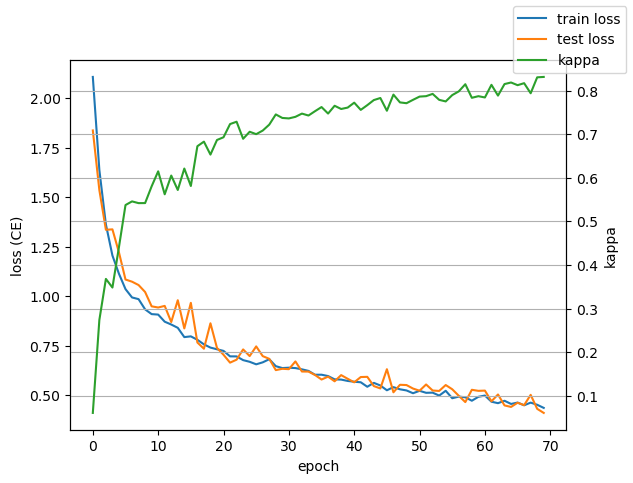

In [137]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.73      0.84      0.78      1041
         2.0       1.00      0.92      0.96       719
         3.0       1.00      1.00      1.00       243
         4.0       0.99      0.96      0.98       960
         5.0       0.93      0.83      0.88       774
         6.0       0.82      0.89      0.85       926
         7.0       0.76      0.76      0.76       964
         8.0       0.69      0.55      0.61       373

    accuracy                           0.85      6000
   macro avg       0.86      0.84      0.85      6000
weighted avg       0.86      0.85      0.85      6000



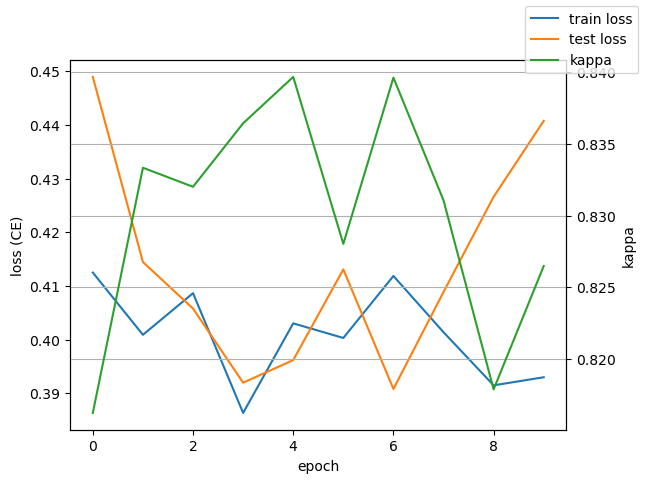

In [141]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))